**AllLife Bank Customer Segmentation**

![](https://i.insider.com/5dd85b74fd9db258cc3ab49e?width=700)

**Context**</br>
* AllLife Bank wants to focus on its credit card customer base in the next financial year. 
* They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. 
* Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. 
* Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help

**Objective**</br>
To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.

**Data Description**
The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

* Sl_No: Primary key of the records
* Customer Key: Customer identification number
* Average Credit Limit: Average credit limit of each customer for all credit cards
* Total credit cards: Total number of credit cards possessed by the customer
* Total visits bank: Total number of visits that customer made (yearly) personally to the bank
* Total visits online: Total number of visits or online logins made by the customer (yearly)
* Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

**Import the Libraries needed**


In [1]:
!pip install scikit-learn-extra
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 936.9 kB/s eta 0:00:00


In [2]:
#Import all the necessary packages

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

#to scale the data using z-score 
from sklearn.preprocessing import StandardScaler

#importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture


#installing and importing the sklearn_extra library

from sklearn_extra.cluster import KMedoids


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')# To supress warnings



# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.datasets import make_blobs


# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer


# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to compute distances
from scipy.spatial.distance import pdist

# to perform PCA
from sklearn.decomposition import PCA


# Printing style
from tabulate import tabulate


# set the background for the graphs
plt.style.use('ggplot')

sns.set_style('whitegrid')
sns.set_palette('Accent')

# Library to suppress warnings or deprecation notes 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


print("Import Libraries  Completed Successfully ")



Import Libraries  Completed Successfully 



# Loading and exploring the data


In [3]:
#Read the Data Source file
data=pd.read_excel("../input/credit-card-customer-data/CreditCardCustomerData.xlsx")


In [4]:
# Retaining the actual file and taking a copy of input as working file
cccd = data.copy()

Lets check the shape and sample records in the dataset

In [5]:
cccd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Observation**
* There are 660 observations and 7 columns in the dataset.
* All columns have 660 non-null values i.e. there are no missing values.
* All columns are of int64 data type.
* There are no missing values

In [6]:
#figure out the uniques in each column
cccd.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

**Observation**
* Customer key, which is an identifier, has repeated values. 

**Data Preprocessing and Exploratory Data Analysis**

Identify and drop the rows with duplicated customer keys

In [7]:

# Identify the duplicated customer keys
duplicate_keys = cccd.duplicated('Customer Key') == True
duplicate_keys

0      False
1      False
2      False
3      False
4      False
       ...  
655    False
656    False
657    False
658    False
659    False
Length: 660, dtype: bool

In [8]:
# Drop duplicated keys

cccd = cccd[duplicate_keys == False]

In [9]:
# drop the columns that is not needed for the Analysis
cccd.drop(columns = ['Sl_No', 'Customer Key'], inplace = True)

In [10]:
cccd[cccd.duplicated()]

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


In [11]:
# We can drop these duplicated rows from the data

cccd=cccd[~cccd.duplicated()]
cccd.shape

(644, 5)

**Observation**

After removing duplicated keys and rows and unnecessary columns, there are 644 unique observations and 5 columns in our data.

**Summary Statistics**

In [12]:
cccd.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,644.0,34543.478261,37428.704286,3000.0,11000.0,18000.0,48000.00,200000.0
Total_Credit_Cards,644.0,4.694099,2.175338,1.0,3.0,5.0,6.00,10.0
Total_visits_bank,644.0,2.395963,1.626964,0.0,1.0,2.0,4.00,5.0
Total_visits_online,644.0,2.624224,2.957728,0.0,1.0,2.0,4.00,15.0
Total_calls_made,644.0,3.608696,2.880025,0.0,1.0,3.0,5.25,10.0


**Observations:**

* Credit limit average is around 35K with 50% of customers having a credit limit less than 18K, which implies a high positive skewness.
* Looking at standard deviation, we can see a considerably high variation in credit limits as well.
* On average, credit cards owned by each customer are ~5. Some customers have 10
* On average, most customer interactions are through calls, then online. Also, some customers never contacted/visited the bank.

In [13]:
np.random.seed(1)  # To get the same random results every time
display(cccd.sample(8))  # Print sample records
print(f'\nThere are {cccd.shape[0]} rows and {cccd.shape[1]} columns.\n')  # Shape of the input file


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
368,20000,4,3,0,3
453,74000,4,4,0,3
471,48000,6,3,2,2
396,73000,6,4,2,0
516,32000,7,4,0,3
470,37000,5,5,1,4
556,60000,4,5,0,4
588,55000,4,3,1,0



There are 644 rows and 5 columns.



**Now let's go ahead with the exploring each variable at hand. We will check the distribution and outliers for each variable in the data.**

In [14]:
# inspect data, print top 5 
cccd.head(5)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


In [15]:
# bottom 5 rows:
cccd.tail(5)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,99000,10,1,10,0
656,84000,10,1,13,2
657,145000,8,1,9,1
658,172000,10,1,15,0
659,167000,9,0,12,2


In [16]:
#undesrtand the Data quality(completeness , uniqueness )
print ("Rows     : " , cccd.shape[0])  #get number of rows/observations
print ("Columns  : " , cccd.shape[1]) #get number of columns
print ("#"*40,"\n","Features : \n\n", cccd.columns.tolist()) #get name of columns/features
print ("#"*40,"\nMissing values :\n\n", cccd.isnull().sum().sort_values(ascending=False))
print( "#"*40,"\nPercent of missing :\n\n", round(cccd.isna().sum() / cccd.isna().count() * 100, 2)) # looking at columns with most Missing Values
print ("#"*40,"\nUnique values :  \n\n", cccd.nunique())  #  count of unique values
print ("#"*40,"\nDuplicate Values:  \n\n",cccd.duplicated().sum())  # check number of duplicate records


Rows     :  644
Columns  :  5
######################################## 
 Features : 

 ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
######################################## 
Missing values :

 Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64
######################################## 
Percent of missing :

 Avg_Credit_Limit       0.0
Total_Credit_Cards     0.0
Total_visits_bank      0.0
Total_visits_online    0.0
Total_calls_made       0.0
dtype: float64
######################################## 
Unique values :  

 Avg_Credit_Limit       109
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64
######################################## 
Duplicate Values:  

 0


Avg_Credit_Limit
Skew : 2.19


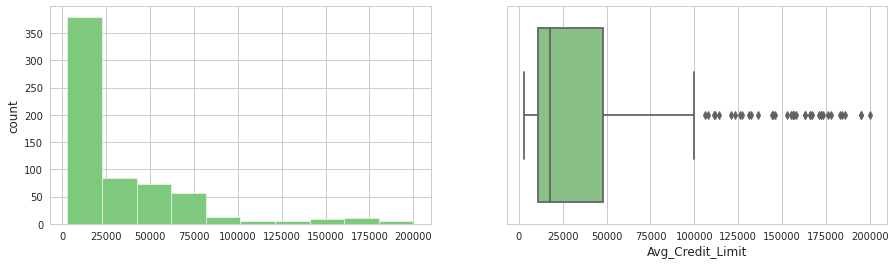

Total_Credit_Cards
Skew : 0.17


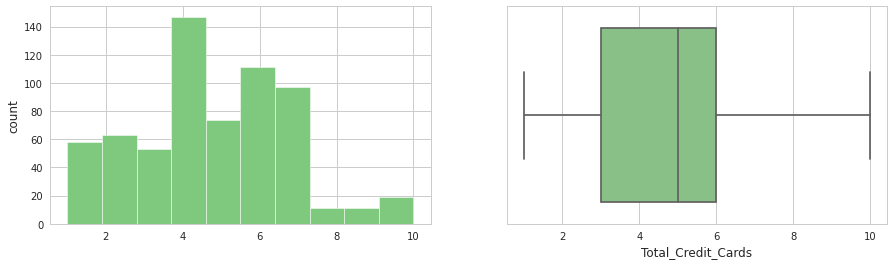

Total_visits_bank
Skew : 0.15


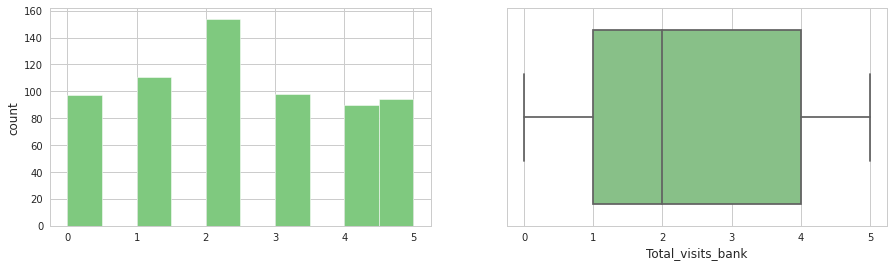

Total_visits_online
Skew : 2.21


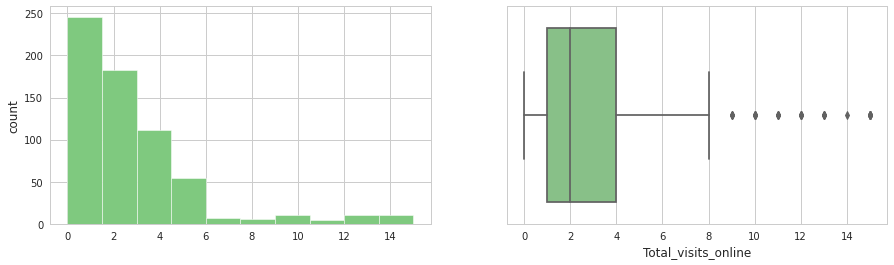

Total_calls_made
Skew : 0.65


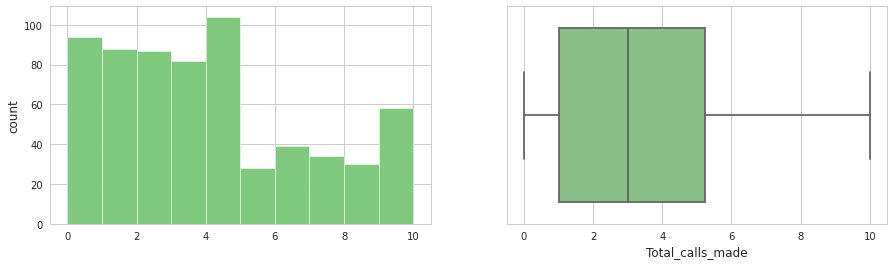

In [17]:
for col in cccd.columns:
     print(col)
     print('Skew :',round(cccd[col].skew(),2))
     plt.figure(figsize=(15,4))
     plt.subplot(1,2,1)
     cccd[col].hist()
     plt.ylabel('count')
     plt.subplot(1,2,2)
     sns.boxplot(x=cccd[col])
     plt.show()

**Observations**

* Many outliers in average credit limit. High credit customers are causing skewness.
* Online visits are mostly between 1 and 4 with some outliers with more than 7 and above.

**Exploratory Data Analysis EDA**

***Univariate Analysis***

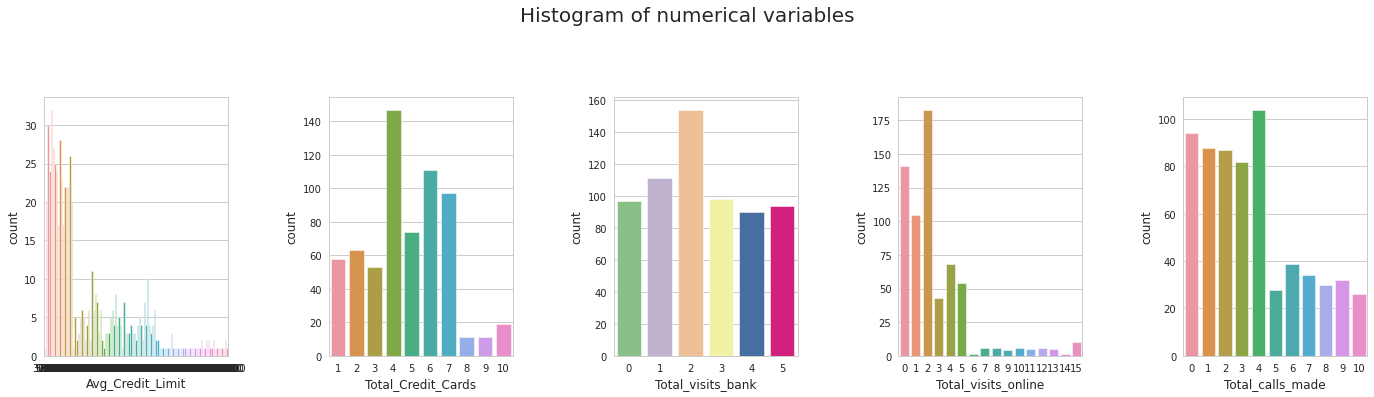

In [18]:
all_col = cccd.iloc[:,:].columns.tolist()
fig, axes = plt.subplots(1, 5,  figsize=(20, 6))
fig.suptitle('Histogram of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.countplot(ax=axes[ii],x=cccd[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=4.0)

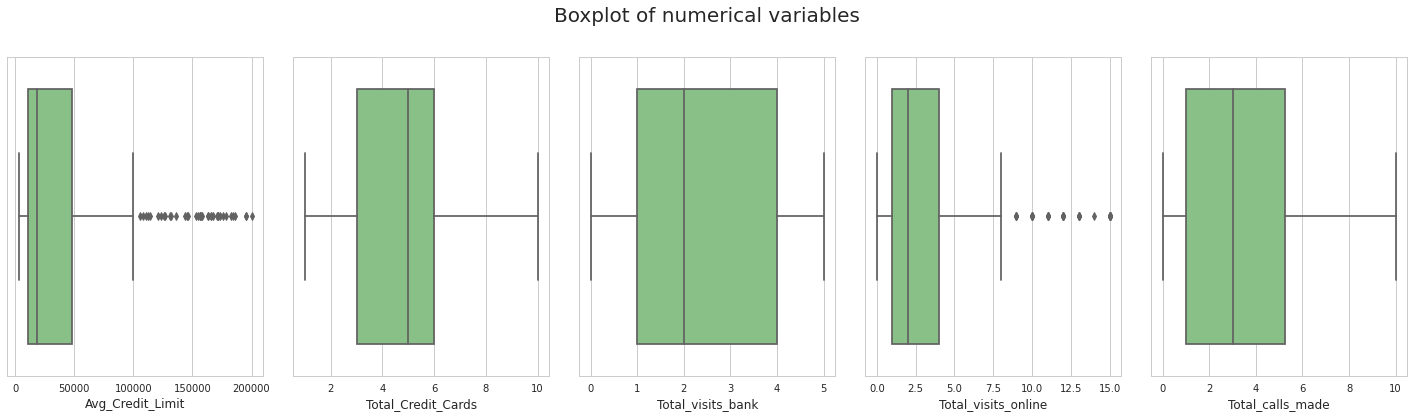

In [19]:
fig, axes = plt.subplots(1, 5,  figsize=(20, 6))
fig.suptitle('Boxplot of numerical variables', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],x=cccd[all_col[counter]])
    counter = counter+1

fig.tight_layout(pad=2.0)

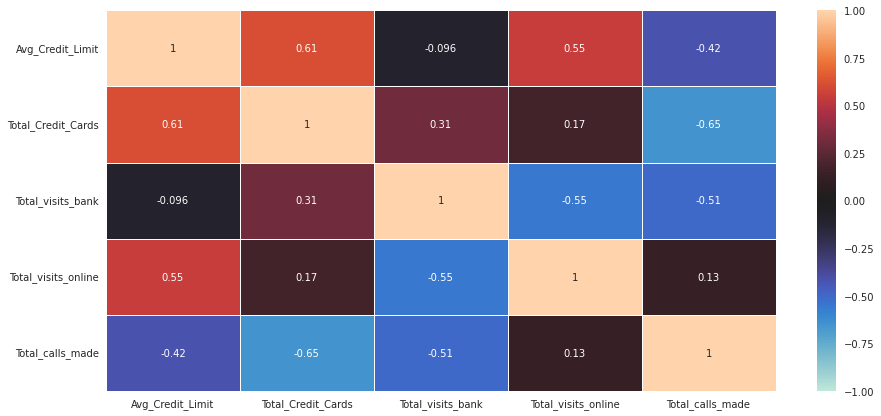

In [20]:
plt.figure(figsize=(15,7))

sns.heatmap(cccd[all_col].corr(),
            annot=True,
            linewidths=0.5,vmin=-1,vmax=1,
            center=0,
            cbar=True,)

plt.show()

**Observations**


* Avg_Credit_Limit is positively correlated with Total_Credit_Cards 
* Total_visits_online which can makes sense.
* Avg_Credit_Limit is negatively correlated with Total_calls_made and Total_visits_bank.
* Total_visits_bank, Total_visits_online, Total_calls_made are negatively correlated which implies that majority of customers use only one of these channels to contact the bank.

**Univariate Analysis Adv**
* check the distribution/spread of the data. using primarily histograms and box plots. 
* Additionally we'll plot each numerical feature on violin plot and cumulative density distribution plot. 

* For these 4 kind of plots, we are building below summary() function to plot each of the numerical attributes. Also, we'll display feature-wise 5 point summary.

In [21]:
def summary(data: pd.DataFrame, x: str):
    '''
    The function prints the 5 point summary and histogram, box plot, 
    violin plot, and cumulative density distribution plots for each 
    feature name passed as the argument.
    
    Parameters:
    ----------
    
    data: pd.Datafraame, the dataset
    x: str, feature name
    
    Usage:
    ------------
    
    summary(data, 'age')
    '''
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)
    
    dict={'Min': x_min, 'Q1': Q1, 'Q2': Q2, 'Q3': Q3, 'Max': x_max}
    df = pd.DataFrame(data=dict, index=['Value'])
    print(f'5 Point Summary of {x.capitalize()} Attribute:\n')
    print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

    fig = plt.figure(figsize=(16, 8))
    plt.subplots_adjust(hspace = 0.6)
    sns.set_palette('Pastel1')
    
    plt.subplot(221, frameon=True)
    ax1 = sns.distplot(data[x], color = 'purple')
    ax1.axvline(
        np.mean(data[x]), color="purple", linestyle="--"
    )  # Add mean to the histogram
    ax1.axvline(
        np.median(data[x]), color="black", linestyle="-"
    )  # Add median to the histogram
    plt.title(f'{x.capitalize()} Density Distribution')
    
    plt.subplot(222, frameon=True)
    ax2 = sns.violinplot(x = data[x], palette = 'Accent', split = True)
    plt.title(f'{x.capitalize()} Violinplot')
    
    plt.subplot(223, frameon=True, sharex=ax1)
    ax3 = sns.boxplot(x=data[x], palette = 'cool', width=0.7, linewidth=0.6, showmeans=True)
    plt.title(f'{x.capitalize()} Boxplot')
    
    plt.subplot(224, frameon=True, sharex=ax2)
    ax4 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f'{x.capitalize()} Cumulative Density Distribution')
    
    plt.show()

In [22]:
print('We will check the summary of below columns: \n', cccd.columns.tolist())

We will check the summary of below columns: 
 ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']


5 Point Summary of Avg_credit_limit Attribute:

+-------+-------+-------+-------+-------+--------+
|       |   Min |    Q1 |    Q2 |    Q3 |    Max |
|-------+-------+-------+-------+-------+--------|
| Value |  3000 | 11000 | 18000 | 48000 | 200000 |
+-------+-------+-------+-------+-------+--------+


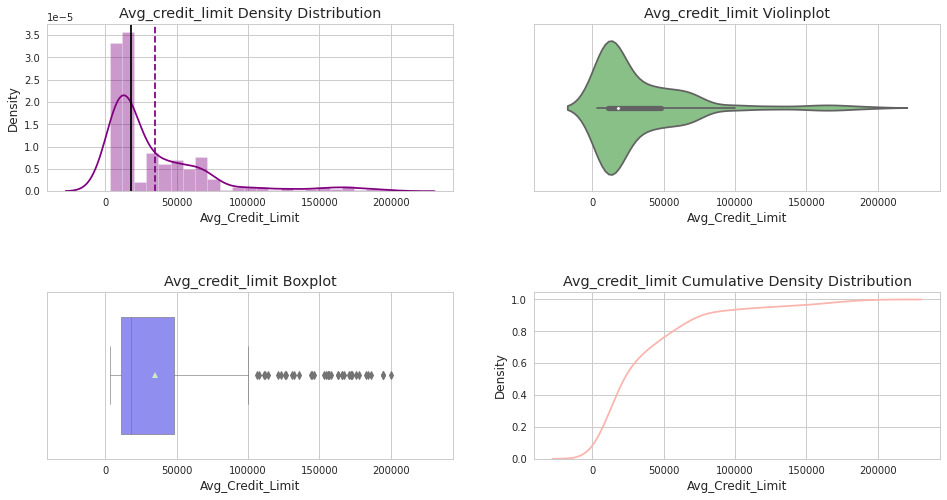

In [23]:
#Summary of Avergae Credit Limit
summary(cccd, 'Avg_Credit_Limit')

**Observation**
* The attribute is right skewed with a lot of outliers

5 Point Summary of Total_credit_cards Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     1 |    3 |    5 |    6 |    10 |
+-------+-------+------+------+------+-------+


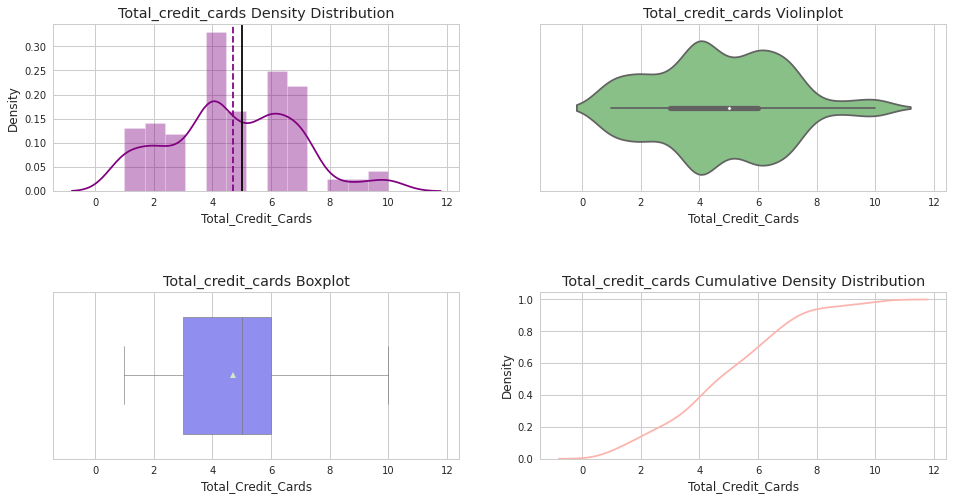

In [24]:
#Summary of Total_Credit_Cards
summary(cccd, 'Total_Credit_Cards')

**Observation**
* The attribute is fairly normally distributed with a few spikes

5 Point Summary of Total_visits_bank Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    2 |    4 |     5 |
+-------+-------+------+------+------+-------+


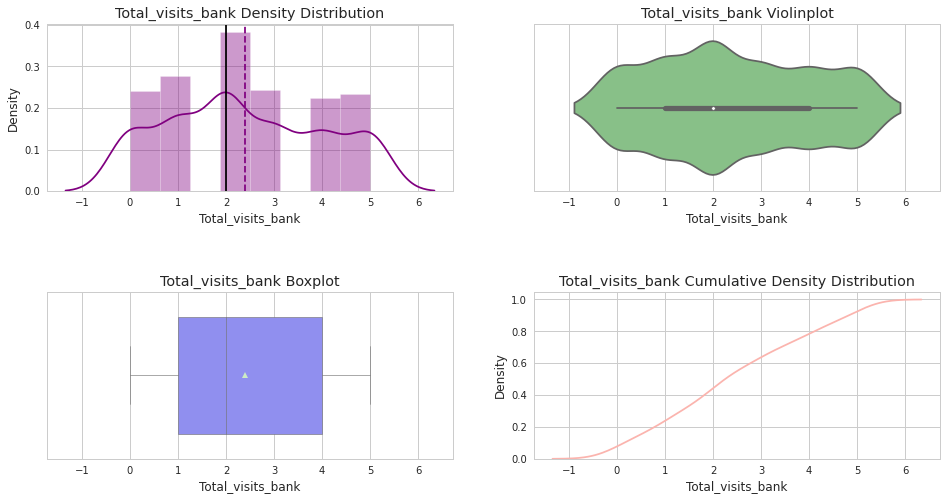

In [25]:
#Summary of Total_visits_bank
summary(cccd, 'Total_visits_bank')

**Observation**
* The data is slightly right skewed

5 Point Summary of Total_visits_online Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    2 |    4 |    15 |
+-------+-------+------+------+------+-------+


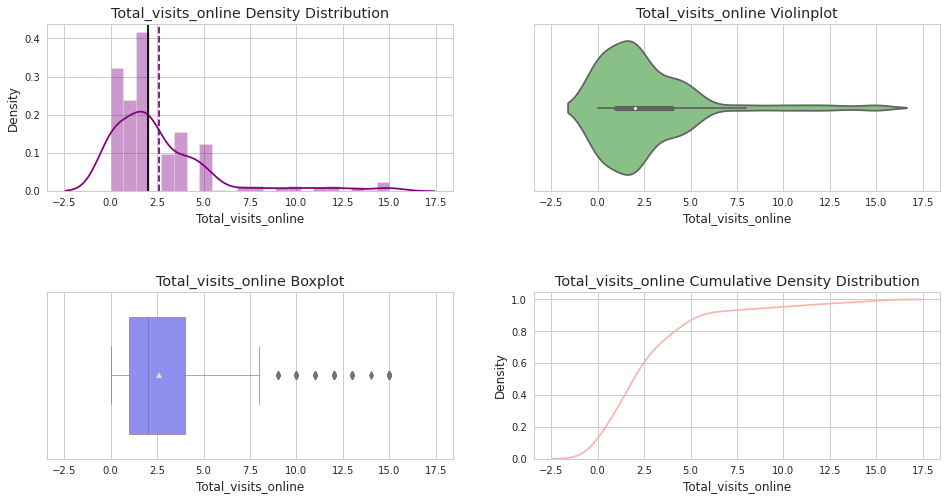

In [26]:
#Summary of Total_visits_online
summary(cccd, 'Total_visits_online')

**Observations**
* The data is right skewed and has some outliers to the right

5 Point Summary of Total_calls_made Attribute:

+-------+-------+------+------+------+-------+
|       |   Min |   Q1 |   Q2 |   Q3 |   Max |
|-------+-------+------+------+------+-------|
| Value |     0 |    1 |    3 | 5.25 |    10 |
+-------+-------+------+------+------+-------+


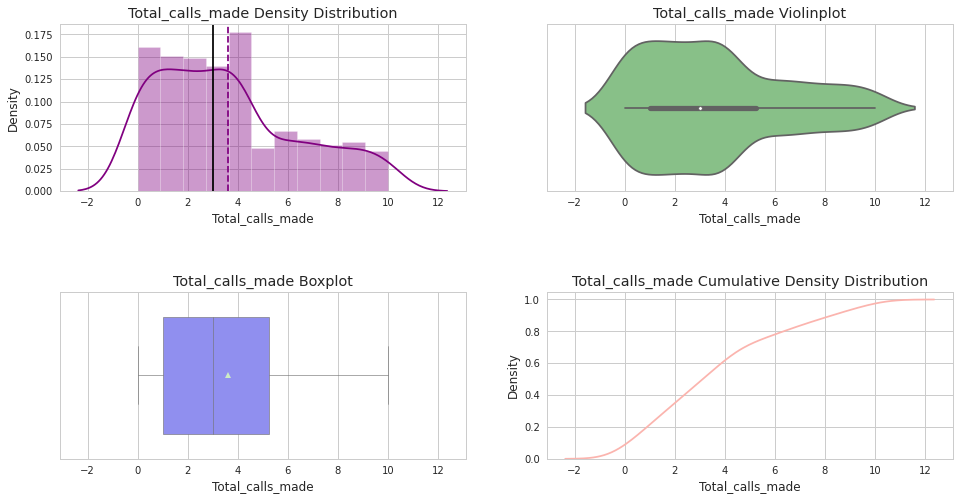

In [27]:
#Summary of Total_calls_made
summary(cccd, 'Total_calls_made')

**Observation**
* The data is right skewed

**Outlier Determination**

In [28]:
def frac_outside_1pt5_IQR(x):
    length = 1.5 * np.diff(np.quantile(x, [.25, .75]))
    return np.mean(np.abs(x - np.median(x)) > length[0])

num_cols=['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']

for i in num_cols:
    print(i+' variable')
    print('Before log ',frac_outside_1pt5_IQR(cccd[i])*100)
    print('After log ',frac_outside_1pt5_IQR(np.log(cccd[i]))*100,'\n')

Avg_Credit_Limit variable
Before log  9.006211180124224
After log  2.329192546583851 

Total_Credit_Cards variable
Before log  2.950310559006211
After log  9.006211180124224 

Total_visits_bank variable
Before log  0.0
After log  15.062111801242237 

Total_visits_online variable
Before log  7.608695652173914
After log  21.8944099378882 

Total_calls_made variable
Before log  4.037267080745342
After log  14.596273291925465 



In [29]:
#Function to calculate and display outlier values

def outlier_values(df,col):
    ''' 
    Calculate and display outlier values which are > 4*IQR
    '''
    print('Determining outlier values for: ',col)
    quartiles = np.quantile(df[col][df[col].notnull()], [.25, .75])
    col_4iqr = 4 * (quartiles[1] - quartiles[0])
    print(f'\nQ1 = {quartiles[0]}, Q3 = {quartiles[1]}, 4*IQR = {col_4iqr}')
    outlier_vals = df.loc[np.abs(df[col] - df[col].median()) > col_4iqr, col]
    print('\nOutlier values:\n',np.sort(outlier_vals.unique()))
    print('---------------------------------------------------------')

cols=['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']
for i in cols:
    outlier_values(cccd,i)

Determining outlier values for:  Avg_Credit_Limit

Q1 = 11000.0, Q3 = 48000.0, 4*IQR = 148000.0

Outlier values:
 [167000 171000 172000 173000 176000 178000 183000 184000 186000 195000
 200000]
---------------------------------------------------------
Determining outlier values for:  Total_Credit_Cards

Q1 = 3.0, Q3 = 6.0, 4*IQR = 12.0

Outlier values:
 []
---------------------------------------------------------
Determining outlier values for:  Total_visits_bank

Q1 = 1.0, Q3 = 4.0, 4*IQR = 12.0

Outlier values:
 []
---------------------------------------------------------
Determining outlier values for:  Total_visits_online

Q1 = 1.0, Q3 = 4.0, 4*IQR = 12.0

Outlier values:
 [15]
---------------------------------------------------------
Determining outlier values for:  Total_calls_made

Q1 = 1.0, Q3 = 5.25, 4*IQR = 17.0

Outlier values:
 []
---------------------------------------------------------


In [30]:
# Lets treat outliers by flooring and capping
def treat_outliers(df,col):
   
    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1
    Lower_Whisker = Q1 - 1.5*IQR 
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker) # all the values samller than Lower_Whisker will be assigned value of Lower_whisker 
                                                            # and all the values above upper_whisker will be assigned value of upper_Whisker 
    return df

def treat_outliers_all(df, col_list): # treat outliers in numerical column of Dataframe
    
    for c in col_list:
        df = treat_outliers(df,c)
        
        
    return df 

In [31]:
numerical_col = ('Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made')
#Applying outlier treatment
cccd = treat_outliers_all(cccd,numerical_col)

**Labeled Bar-plots**

Creating a function to plot labeled bar plot of the features, with percentage label on data bars.

In [32]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 3))
    else:
        plt.figure(figsize=(n + 1, 3))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot


In [33]:
print('We will check the summary of below columns: \n', cccd.columns.tolist())

We will check the summary of below columns: 
 ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']


In [34]:
#Creating a credit card limit bin out of the available data in the avg credit limit feature

cccd['cc_spending_bin'] = pd.cut(cccd['Avg_Credit_Limit'], bins=[3000,	10000,	18000, 	48000,	200000]
                                ,labels=['Very Low', 'Low', 'Mid', 'High'], include_lowest=True)

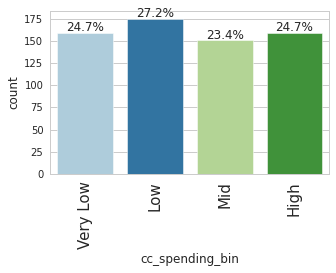

In [35]:
#Credit Card Limit Bins
labeled_barplot(cccd, 'cc_spending_bin', perc=True)

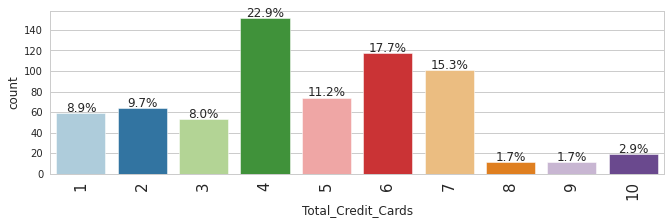

In [36]:
# Total Credit Cards
labeled_barplot(data, 'Total_Credit_Cards', perc=True)

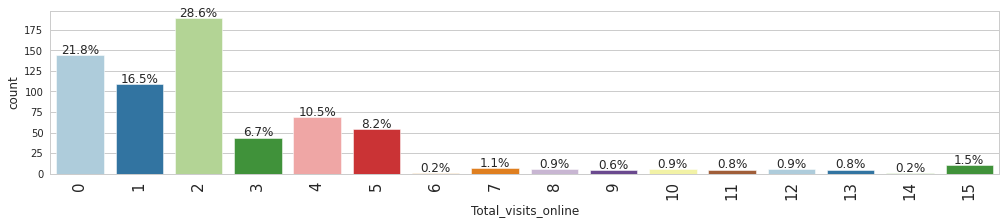

In [37]:
# Total_visits_online
labeled_barplot(data, 'Total_visits_online', perc=True)

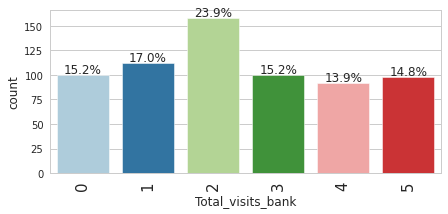

In [38]:
# Total_visits_bank
labeled_barplot(data, 'Total_visits_bank', perc=True)

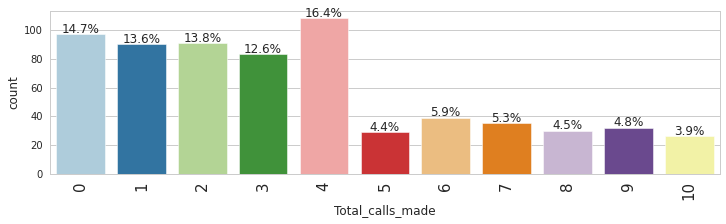

In [39]:
# Total_calls_made
labeled_barplot(data, 'Total_calls_made', perc=True)

**Bi-variate Analysis**

Pair Plot

<Figure size 1440x1440 with 0 Axes>

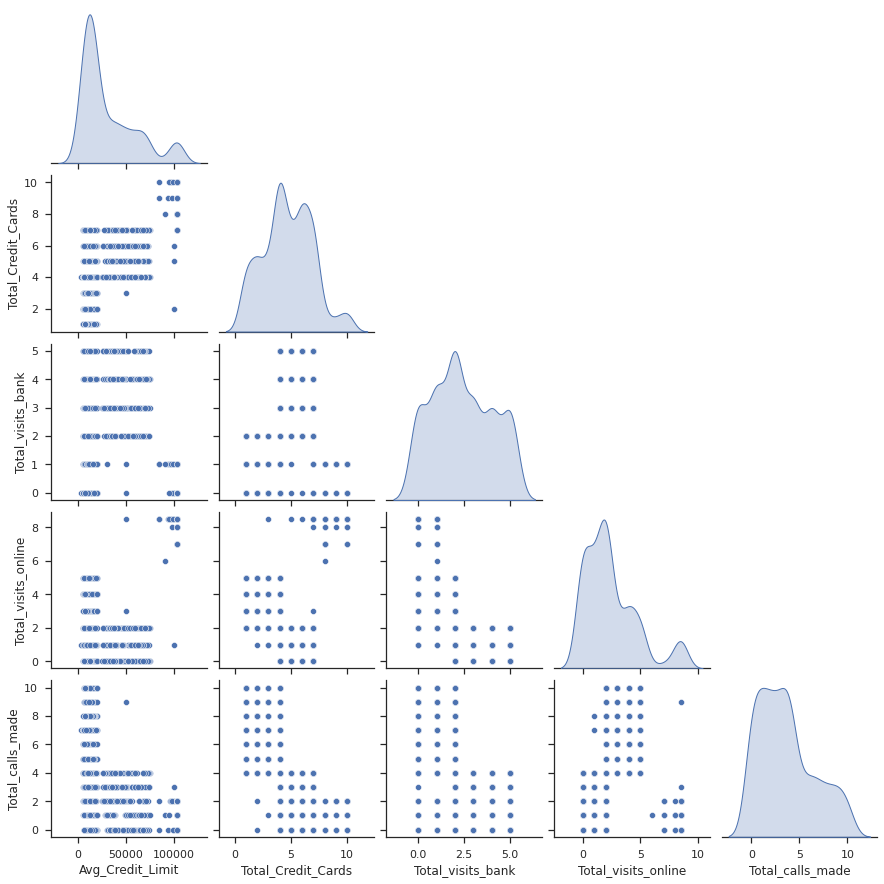

In [40]:
plt.figure(figsize=(20,20));
sns.set(palette="Set2");
sns.set(style="ticks", color_codes=True)
sns.pairplot(cccd.iloc[:, :], diag_kind='kde', corner=True);

**Heat Map**

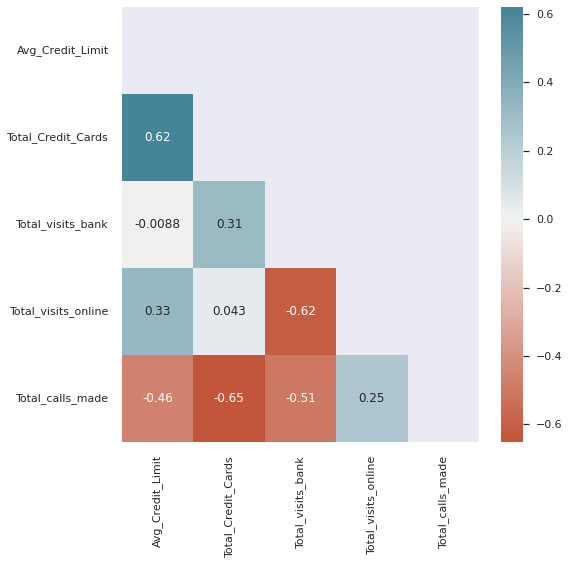

In [41]:
# Plotting correlation heatmap of the features

mask = np.zeros_like(cccd.iloc[:, :].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.set(rc={"figure.figsize": (8, 8)})

sns.heatmap(
    cccd.iloc[:, :].corr(),
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    mask=mask,
    center=0,
)
plt.show()

**Observation**

* Average Credit Limit has slightly positive correlation with Total Credit Cards (obviously) and Total Number of Visits Online, and slightly negative correlation with Total Calls Made
* Total Credit Cards and Total Calls Made are negatively correlated
* Total Visits Online is also negatively correlated with Total Visits to Bank


**Average Credit Limit distribution by Each of the Other Attributes**

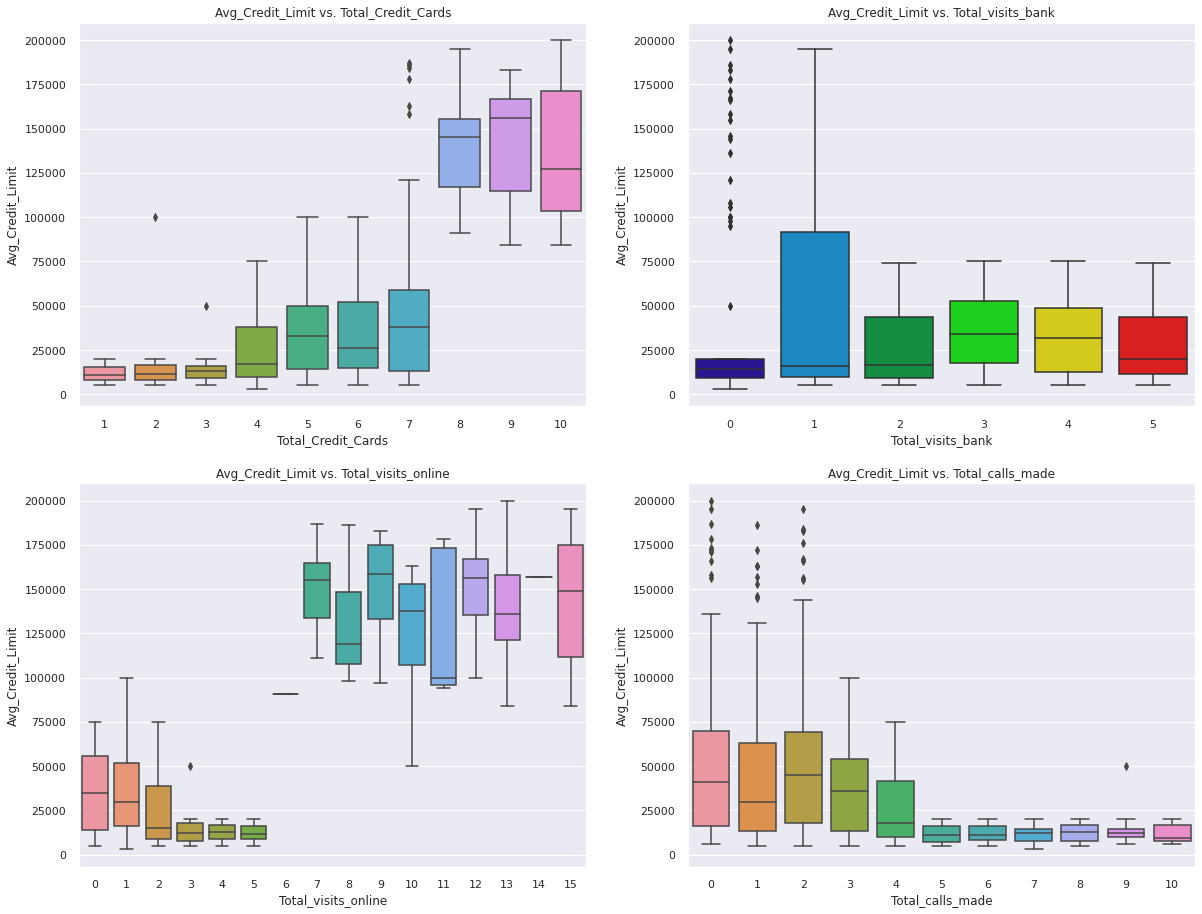

In [42]:
# Function to plot numerical feature by each category with target hue

def plot_numeric_by_cat(data: pd.DataFrame, category_columns: list, numeric_column: str, hue: str = None):
    '''
    The function plots a numerical feature in box plot by every category column specified in the list, 
    with hue of a target category
    '''
    num_cols = 2
    num_rows = int(len(category_columns) /2 + 1)

    plt.figure(figsize=(20, 8*num_rows))
    for i, col in enumerate(category_columns):
        plt.subplot(num_rows, num_cols, i+1)
        sns.set(palette="nipy_spectral");
        sns.boxplot(data=data, x=col, y=numeric_column, hue=hue, showfliers=True).set(title = numeric_column + ' vs. ' + col );
plot_numeric_by_cat(data\
                    ,category_columns=['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']\
                    ,numeric_column='Avg_Credit_Limit')


**We can see clear segmentations with respect to each pair of features**

**Data Preprocessing**

Before clustering, we should always scale the data, because, different scales of features would result in unintentional importance to the feature of higher scale while calculating the distances.

In [43]:
# Scaling the data set before clustering
scaler=StandardScaler()
subset=cccd[all_col].copy()
subset_scaled=scaler.fit_transform(subset)

In [44]:
#Creating a dataframe from the scaled data above
subset_scaled_df=pd.DataFrame(subset_scaled,columns=subset.columns)
subset_scaled_df

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,2.422008,-1.239437,-0.858684,-0.622573,-1.253982
1,0.651470,-0.779381,-1.473803,2.687308,1.873420
2,0.651470,1.060843,-0.858684,0.260062,0.135974
3,-0.056745,0.140731,-0.858684,-0.622573,0.135974
4,2.422008,0.600787,-1.473803,2.687308,-0.211515
...,...,...,...,...,...
639,2.386597,2.441011,-0.858684,2.687308,-1.253982
640,1.855436,2.441011,-0.858684,2.687308,-0.559004
641,2.545945,1.520899,-0.858684,2.687308,-0.906493
642,2.545945,2.441011,-0.858684,2.687308,-1.253982


**K-Means Clustering**

* Finding the best numbr of centroids (K)
* Elbow Curve to get the right number of Clusters

Number of Clusters: 1 	Average Distortion: 2.074598409651341
Number of Clusters: 2 	Average Distortion: 1.4974863000385747
Number of Clusters: 3 	Average Distortion: 1.17916318795359
Number of Clusters: 4 	Average Distortion: 1.0692940335822696
Number of Clusters: 5 	Average Distortion: 1.0020669559430424
Number of Clusters: 6 	Average Distortion: 0.9490539321829538
Number of Clusters: 7 	Average Distortion: 0.9135602249694731
Number of Clusters: 8 	Average Distortion: 0.8895446406445162


Text(0.5, 1.0, 'Selecting k with the Elbow Method')

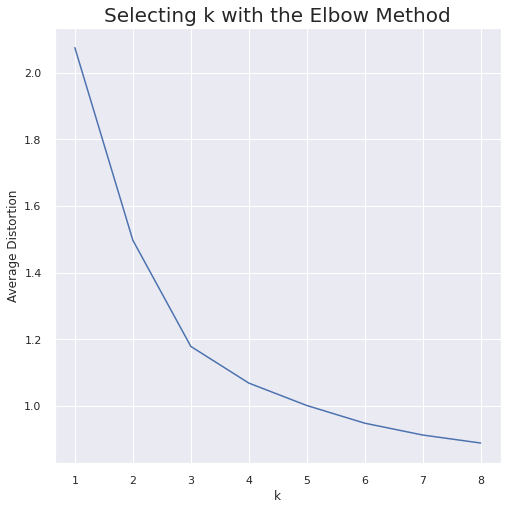

In [45]:
clusters=range(1,9)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(subset_scaled_df)
    prediction=model.predict(subset_scaled_df)
    distortion=sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, 'euclidean'), axis=1)) / subset_scaled_df.shape[0]
                           
    meanDistortions.append(distortion)

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20)

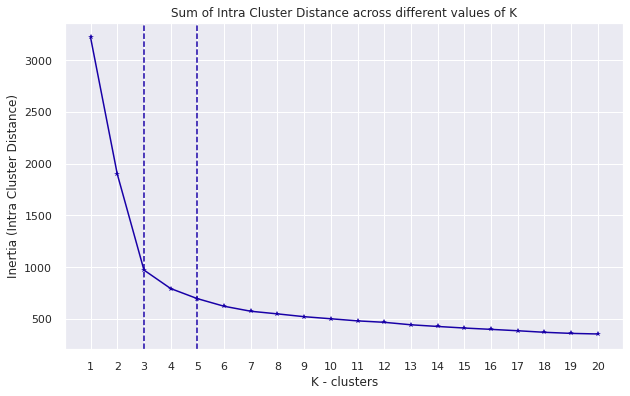

In [46]:
# List to store cluster and intra cluster distance

clusters = []
inertia_vals = (
    []
)  # Variance - Intra cluster sum of distance ; within cluster sum of distance

# Since creating one cluster is similar to observing the data as a whole, multiple values of K are utilized to come up with the optimum cluster value
# Note: Cluster number and intra cluster distance is appended for plotting the elbow curve
for k in range(1, 21, 1):

    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)

    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)
# plot the inertia vs K values

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21, 1), inertia_vals, marker="*")
plt.title("Sum of Intra Cluster Distance across different values of K")
plt.axvline(3, linestyle="--")
plt.axvline(5, linestyle="--")
plt.xlabel("K - clusters")
plt.ylabel("Inertia (Intra Cluster Distance)")

plt.xticks(range(1, 21, 1))

plt.show()

For n_clusters = 2, the silhouette score is 0.5168648770703919)
For n_clusters = 3, the silhouette score is 0.3468438184099733)
For n_clusters = 4, the silhouette score is 0.48152116841436865)
For n_clusters = 5, the silhouette score is 0.4450720611871083)
For n_clusters = 6, the silhouette score is 0.32087938161873153)
For n_clusters = 7, the silhouette score is 0.27088323898020805)
For n_clusters = 8, the silhouette score is 0.2533342221722782)
For n_clusters = 9, the silhouette score is 0.2592784588289341)


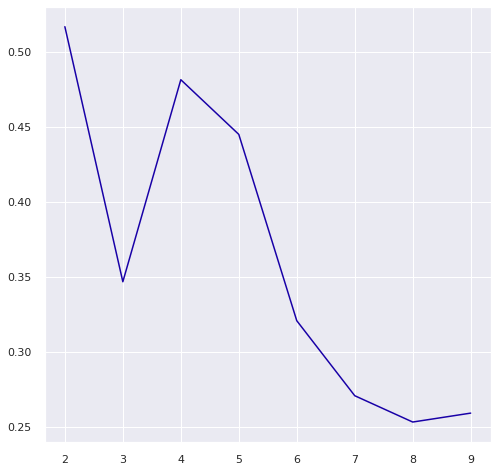

In [47]:
# Getting the silhouette scores to confirm my suspicions on the number of clusters
avg_sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="euclidean", linkage="average"
    )
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    avg_sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, avg_sil_score)
plt.show()

For n_clusters = 2, the silhouette score is 0.5168648770703919)
For n_clusters = 3, the silhouette score is 0.5159892955616765)
For n_clusters = 4, the silhouette score is 0.345959789955619)
For n_clusters = 5, the silhouette score is 0.31508656517317163)
For n_clusters = 6, the silhouette score is 0.28069116682892775)
For n_clusters = 7, the silhouette score is 0.2330079393524261)
For n_clusters = 8, the silhouette score is 0.2488515823324769)
For n_clusters = 9, the silhouette score is 0.24871442581000497)


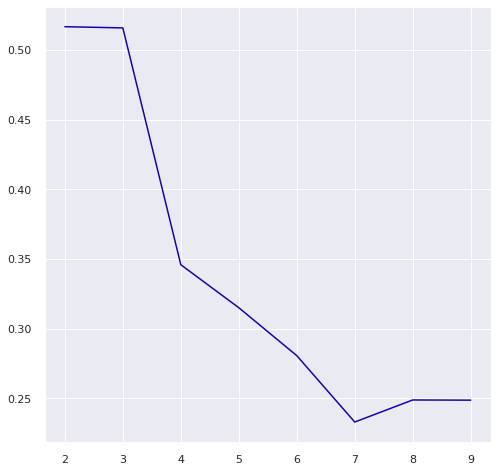

In [48]:
# Getting the silhouette scores to confirm my suspicions on the number of clusters
complete_sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = AgglomerativeClustering(
        n_clusters=n_clusters, affinity="euclidean", linkage="complete"
    )
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    complete_sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, complete_sil_score)
plt.show()

**Observation**

The appropriate value of k from elbow curve seems to be 3 , 4 or 5

In [49]:
# Finding the difference between each value so we can graph it
abs_diff = []

for i in range(0, len(inertia_vals) - 1):

    diff = round((inertia_vals[i] - inertia_vals[i + 1]) / inertia_vals[i], 2)

    abs_diff.append(diff)

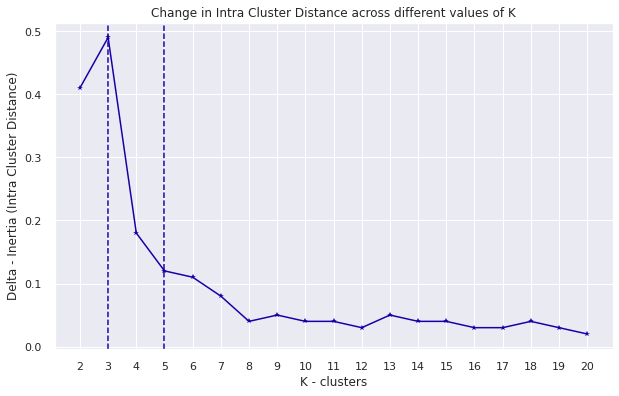

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(range(2, 21, 1), abs_diff, marker="*")
plt.title("Change in Intra Cluster Distance across different values of K")
plt.xlabel("K - clusters")
plt.ylabel("Delta - Inertia (Intra Cluster Distance)")

plt.xticks(range(2, 21, 1))

plt.axvline(3, linestyle="--")
plt.axvline(5, linestyle="--")

plt.show()

**Observation**
The change from 2 to 3 is enormous, with change dramatically decreasing after 3. 3 is starting to look like an excellent number of clusters. Let's look at the silhouette scores.

**Silhouette Score**

For n_clusters = 2, the silhouette score is 0.4199234943770729)
For n_clusters = 3, the silhouette score is 0.5171708525887699)
For n_clusters = 4, the silhouette score is 0.38211792009861434)
For n_clusters = 5, the silhouette score is 0.3558112761862339)
For n_clusters = 6, the silhouette score is 0.2730913695044364)
For n_clusters = 7, the silhouette score is 0.2662025817699087)
For n_clusters = 8, the silhouette score is 0.25507958050598273)
For n_clusters = 9, the silhouette score is 0.25490328334572426)


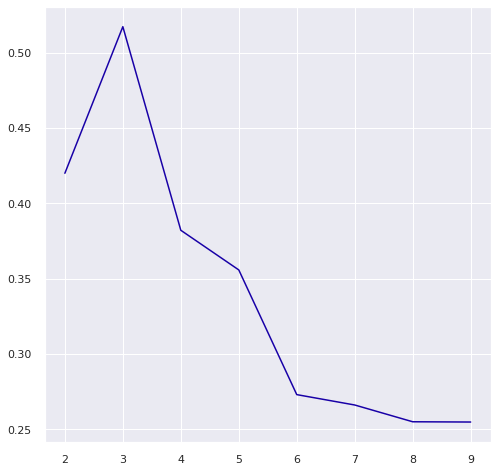

In [51]:
# Getting the silhouette score for each k and adding it to a list to be printed and graphed
sil_score = []
cluster_list = list(range(2, 10))
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict((subset_scaled_df))
    # centers = clusterer.cluster_centers_
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

**Observation**
* Silhouette score for 3 is much higher than 4 and 5. Everything seems to be pointing to 3 clusters being the best k.

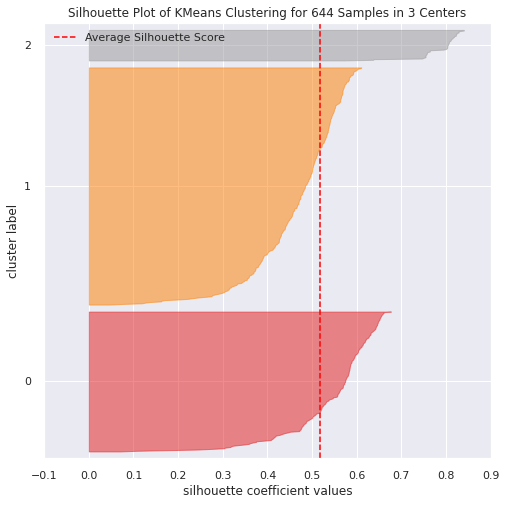

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 644 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [52]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

**Observation**
As expected, all three clusters have excellent silhouette scores. Two of the clusters are similar size, with one being quite small.

**Cluster Profiling**

In [53]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(subset_scaled_df)
KMeans(n_clusters=3, random_state=0)
cccd['K_means_segments'] = kmeans.labels_
cluster_profile = cccd.groupby('K_means_segments').mean()
cluster_profile['count_in_each_segment'] = cccd.groupby('K_means_segments')['Avg_Credit_Limit'].count().values
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,101448.979592,8.775510,0.591837,8.204082,1.102041,49
1,12239.819005,2.411765,0.945701,3.554299,6.891403,221
2,33893.048128,5.508021,3.489305,0.975936,1.997326,374


<AxesSubplot:xlabel='K_means_segments'>

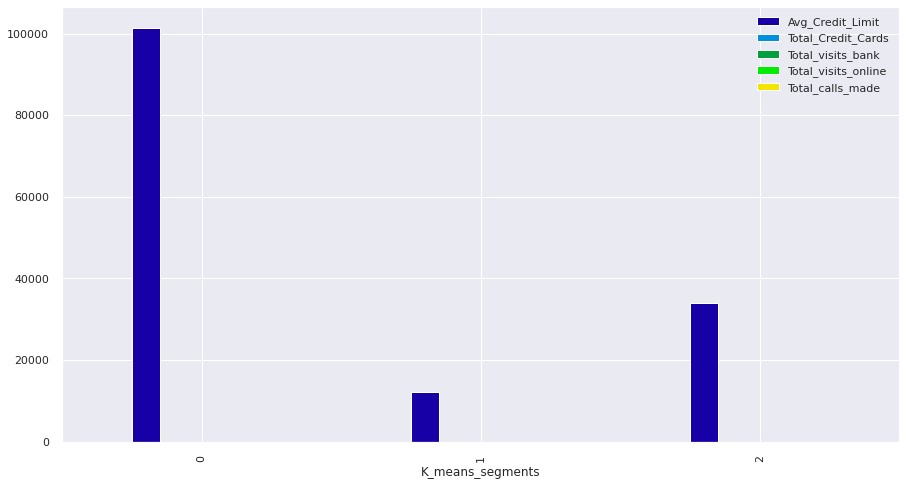

In [54]:
cccd.groupby('K_means_segments').mean().plot.bar(figsize=(15,8))

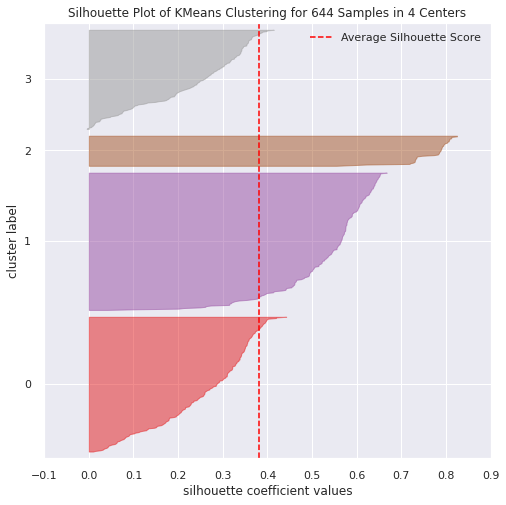

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 644 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [55]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

In [56]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(subset_scaled_df)
KMeans(n_clusters=4, random_state=0)
cccd['K_means_segments'] = kmeans.labels_
cluster_profile = cccd.groupby('K_means_segments').mean()
cluster_profile['count_in_each_segment'] = cccd.groupby('K_means_segments')['Avg_Credit_Limit'].count().values
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,56006.289308,5.522013,3.201258,0.930818,2.081761,159
1,12263.636364,2.404545,0.940909,3.561364,6.904545,220
2,101448.979592,8.775510,0.591837,8.204082,1.102041,49
3,17490.740741,5.490741,3.694444,1.013889,1.944444,216


<AxesSubplot:xlabel='K_means_segments'>

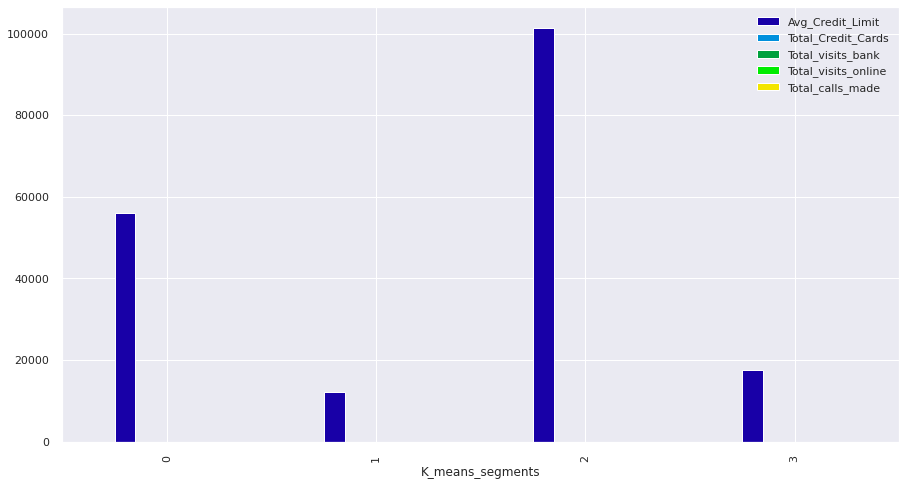

In [57]:
cccd.groupby('K_means_segments').mean().plot.bar(figsize=(15,8))

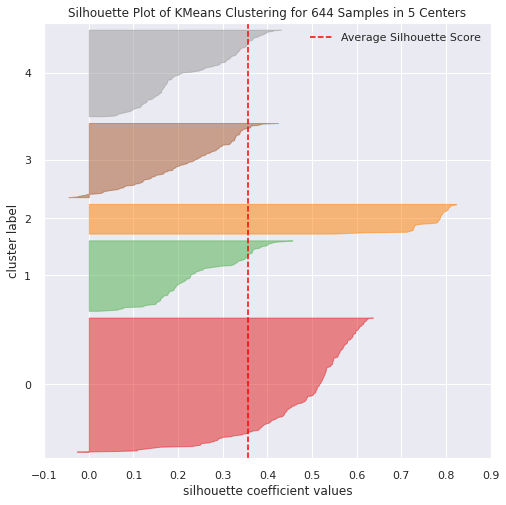

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 644 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [58]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(subset_scaled_df)
visualizer.show()

In [59]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(subset_scaled_df)
KMeans(n_clusters=5, random_state=0)
cccd['K_means_segments'] = kmeans.labels_
cluster_profile = cccd.groupby('K_means_segments').mean()
cluster_profile['count_in_each_segment'] = cccd.groupby('K_means_segments')['Avg_Credit_Limit'].count().values
cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
K_means_segments,,,,,,
0,60704.918033,5.475410,3.163934,0.844262,1.967213,122
1,12258.064516,2.387097,0.940092,3.582949,6.958525,217
2,101448.979592,8.775510,0.591837,8.204082,1.102041,49
3,19191.304348,5.521739,2.443478,1.043478,2.078261,115
4,22042.553191,5.475177,4.560284,1.063830,1.992908,141


<AxesSubplot:xlabel='K_means_segments'>

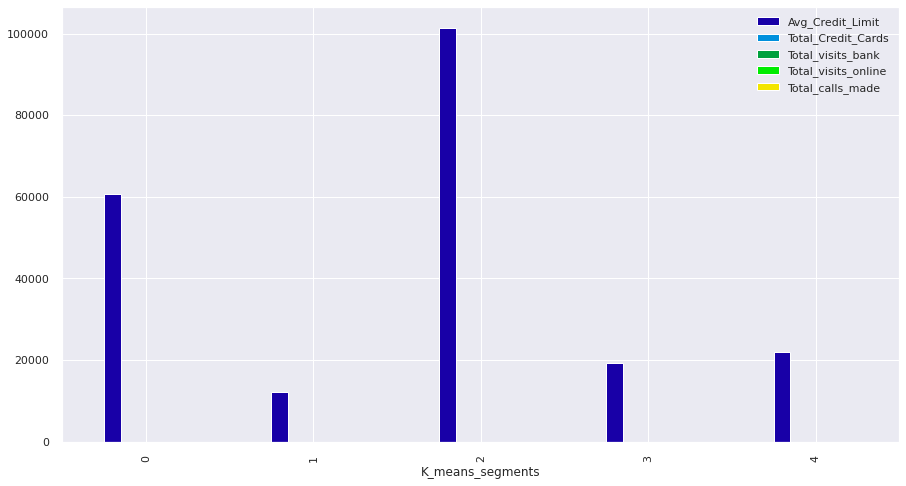

In [60]:
cccd.groupby('K_means_segments').mean().plot.bar(figsize=(15,8))

**k = 3 has by far the lowest DB score, meaning it has the most distinct and separate clusters.**

**Using PCA to examine optimal number of clusters**

In [61]:
# Principal Component Extraction using sklearn.decomposition package
pca = PCA(n_components=5)
pca.fit_transform(subset_scaled_df)
pc_comps = ["PC1", "PC2", "PC3", "PC4", "PC5"]
prop_var = np.round(pca.explained_variance_ratio_, 2)
std_dev = np.round(np.sqrt(pca.explained_variance_), 2)
cum_var = np.round(np.cumsum(pca.explained_variance_ratio_), 2)
temp = pd.DataFrame(pc_comps, columns=["PCs"])
temp["Proportion Of Variance"] = prop_var
temp["Standard Deviation"] = std_dev
temp["Cumulative Proportion"] = cum_var
temp

,PCs,Proportion Of Variance,Standard Deviation,Cumulative Proportion
0,PC1,0.47,1.54,0.47
1,PC2,0.34,1.31,0.82
2,PC3,0.06,0.57,0.88
3,PC4,0.06,0.56,0.94
4,PC5,0.06,0.53,1.00


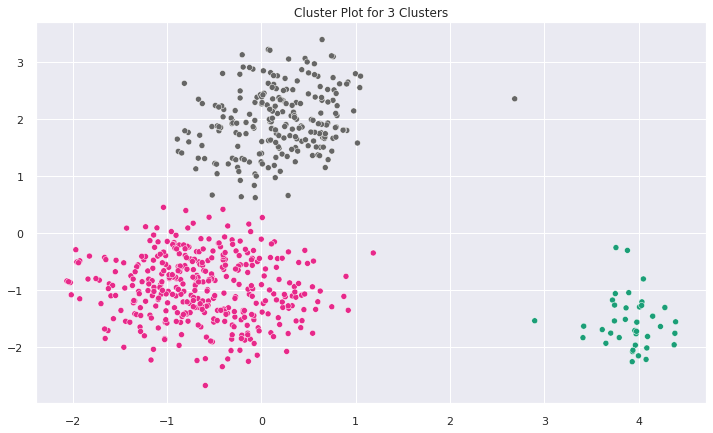

In [62]:
# Making a cluster plot with two PCs based on our scaled dataset.
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(subset_scaled_df)
plt.figure(figsize=(12, 7))
sns.scatterplot(
    x=plot_columns[:, 1],
    y=plot_columns[:, 0],
    hue=KMeans(n_clusters=3, random_state=1)
    .fit(subset_scaled_df)
    .labels_,  # We'll start with 3 clusters
    palette="Dark2_r",
    legend=False,
)
plt.title("Cluster Plot for 3 Clusters")
plt.show()

**Observations**

We will consider k=3 to be the optimal number of clusters. This is because:

* The elbow at k=3 was steepest with a huge drop in inertia
* The highest silhouette score was for k=3 by far
* The gap statistic implies k=3 is best
* The DB score also showed k=3 as best
* The Calinski-Harabasz Index highlighted k=3 as best
* The cluster distribution for k=3 was subjectively very distinct, especially compared to k=5, which was another consideration.
* The PCA graphics all show three distinct groups with little overlap

**From here we see that the three groups are starting to come together. It seems like**

**Group 0: Vocalizers**

* Second largest group
* Very low credit limit
* Low number of credit cards
* Almost never visits the bank or uses online services
* Huge number of calls made

**Group 1: In-Person**

* Largest group
* Mid number of credit cards
* Visits the bank often
* Almost no online usage
* Calls rarely

**Group 2: Online**

* Smallest group, and by a large margine
* Huge credit limit
* Lots of credit cards
* Almost never visits the bank
* Banks online extensively
* Almost never calls

These three groups are defined most sharply by how they interact with the bank, as there is almost no overlap when it comes to their primary interaction variable. For whatever reason, customers seem to overwhelmingly prefer one method of contacting the bank.



**Hierarchical Clustering**

***Distance Measures***

In [63]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:

    print("-" * 50)

    for lm in linkage_methods:

        # -------------------Default is Euclidean Distance for Linkage

        Z = linkage(subset_scaled_df, metric=dm, method=lm)

        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))

        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, round(c, 3)
            )
        )

        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

--------------------------------------------------
Cophenetic correlation for Euclidean distance and single linkage is 0.667.
Cophenetic correlation for Euclidean distance and complete linkage is 0.842.
Cophenetic correlation for Euclidean distance and average linkage is 0.892.
--------------------------------------------------
Cophenetic correlation for Chebyshev distance and single linkage is 0.688.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.794.
Cophenetic correlation for Chebyshev distance and average linkage is 0.891.
--------------------------------------------------
Cophenetic correlation for Mahalanobis distance and single linkage is 0.658.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.364.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.799.
--------------------------------------------------
Cophenetic correlation for Cityblock distance and single linkage is 0.671.
Cophenetic correlation for City

Ideally the cophenetic correlation is high, but it is not the only measure. We'll want to look more deeply into each of the methods. However, it is fairly safe to say that the distance measure with the highest cophenetic correlation is probably the best one to use with that method.

Of course in this case Euclidean distance is the best for all of the methods, but it was worth checking.

Note: Ward only accepts Euclidean, so we'll use that one for ward.

In [64]:
# list of distance metrics
distance_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
        'cosine', 'euclidean', 'hamming', 'jaccard', 'mahalanobis', 'matching', 'minkowski', 'seuclidean',  'sqeuclidean']

# list of linkage methods
linkage_methods = ['complete', 'average', 'single', 'weighted']

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Braycurtis distance and complete linkage is 0.5746158704285411.
Cophenetic correlation for Braycurtis distance and average linkage is 0.6637350405551006.
Cophenetic correlation for Braycurtis distance and single linkage is 0.8062388963038308.
Cophenetic correlation for Braycurtis distance and weighted linkage is 0.6211577203431989.
Cophenetic correlation for Canberra distance and complete linkage is 0.46209730052469394.
Cophenetic correlation for Canberra distance and average linkage is 0.7198335338702938.
Cophenetic correlation for Canberra distance and single linkage is 0.7163706064738385.
Cophenetic correlation for Canberra distance and weighted linkage is 0.5796083643685634.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7944144632337942.
Cophenetic correlation for Chebyshev distance and average linkage is 0.890752938374623.
Cophenetic correlation for Chebyshev distance and single linkage is 0.6881982007870426.
Cophenetic correlat

In [65]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8924686891600743, which is obtained with average linkage.


**Observations**

We see that cophenet index is maximum with cityblock distance metric with manhattan distance method and average linkage method.
Lets see the dendrogram of different linkage method

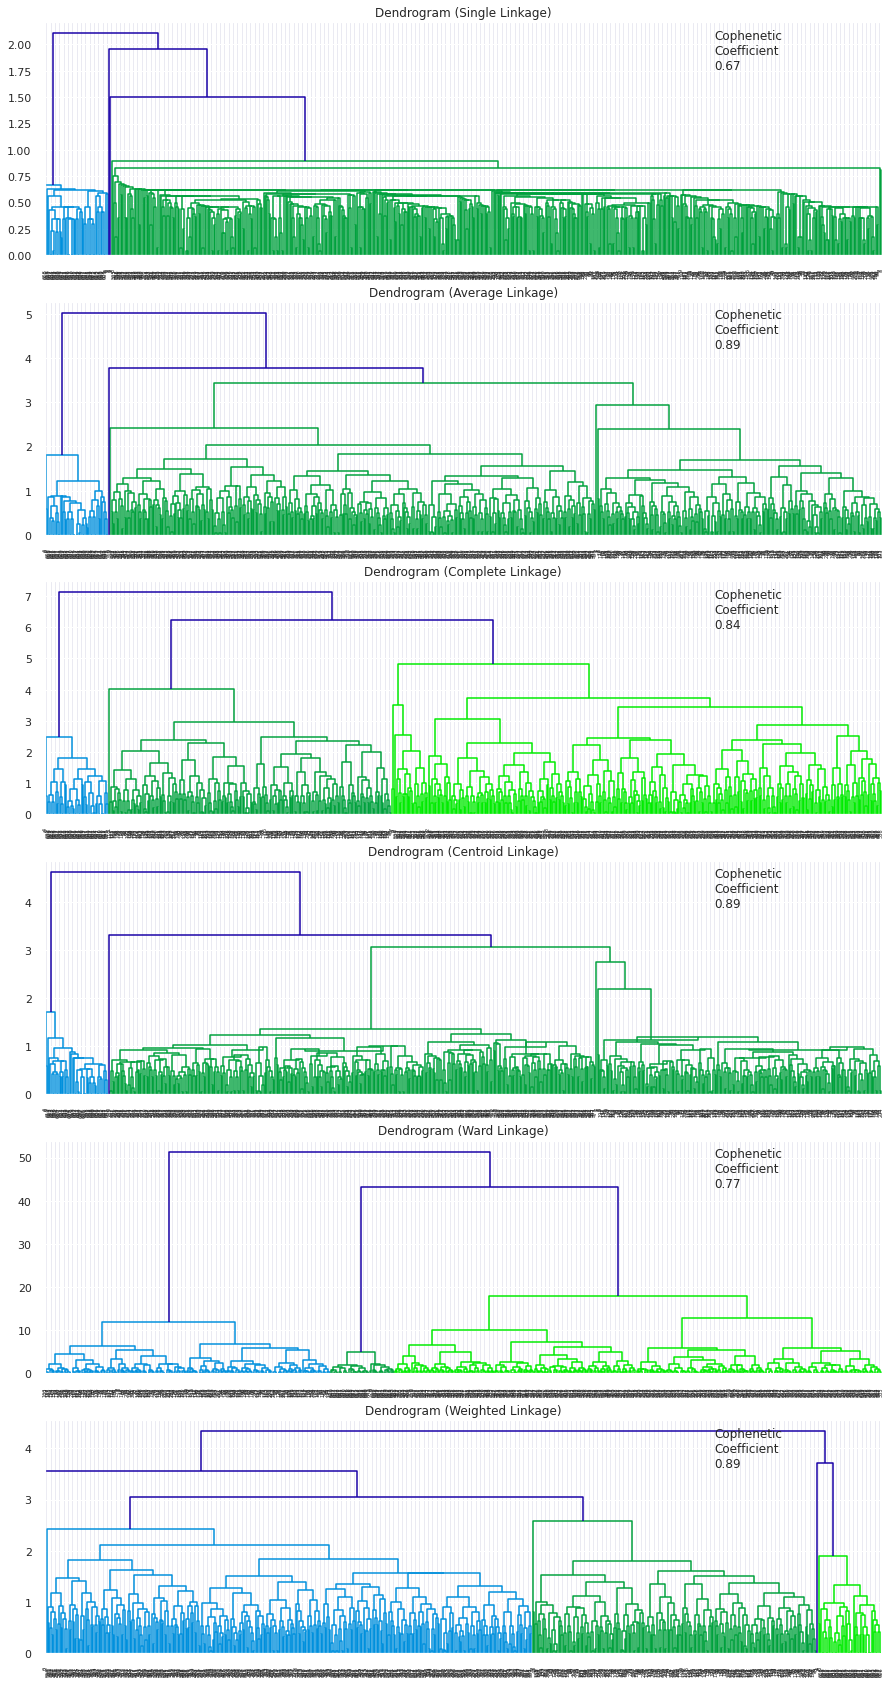

In [66]:
# List of all linkage methods to check
methods = ['single',
           'average', 
           'complete',
           'centroid',
           'ward',
          'weighted']

# Calculate the pairwise distance form the dataset to be used in the cophenetic correlation calculation
#pw_distance = pdist(credit_scaled)

# Create lists to save results of coph calculation
compare_cols = ['Linkage', 'Cophenetic Coefficient']
compare = []

# Create a subplot image
fig, axs = plt.subplots(len(methods), 1, figsize=(15, 30))

# Enumerate through the list of all methods above
# Get linkage, plot dendrogram, calculate cophenetic coefficient
for i, method in enumerate(methods):
    
    Z = linkage(subset_scaled_df, metric='euclidean', method=method)

    dendrogram(Z, ax=axs[i]);
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                    (0.80, 0.80),
                    xycoords='axes fraction')
    compare.append([method, coph_corr])


**Observations**

Dendrogram with ward linkage method shows distinct and separate cluster compared to other clusters

In [67]:
# Create and print dataframe to compare Cophenetic Coefficient for each linkage
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.666649
1,average,0.892469
2,complete,0.842153
3,centroid,0.888550
4,ward,0.767614
5,weighted,0.889728


Let us see the dendrogram of 'mahalanobis','cityblock' with 'average', 'weighted' linkage method as they gave high cophenetic correlation value

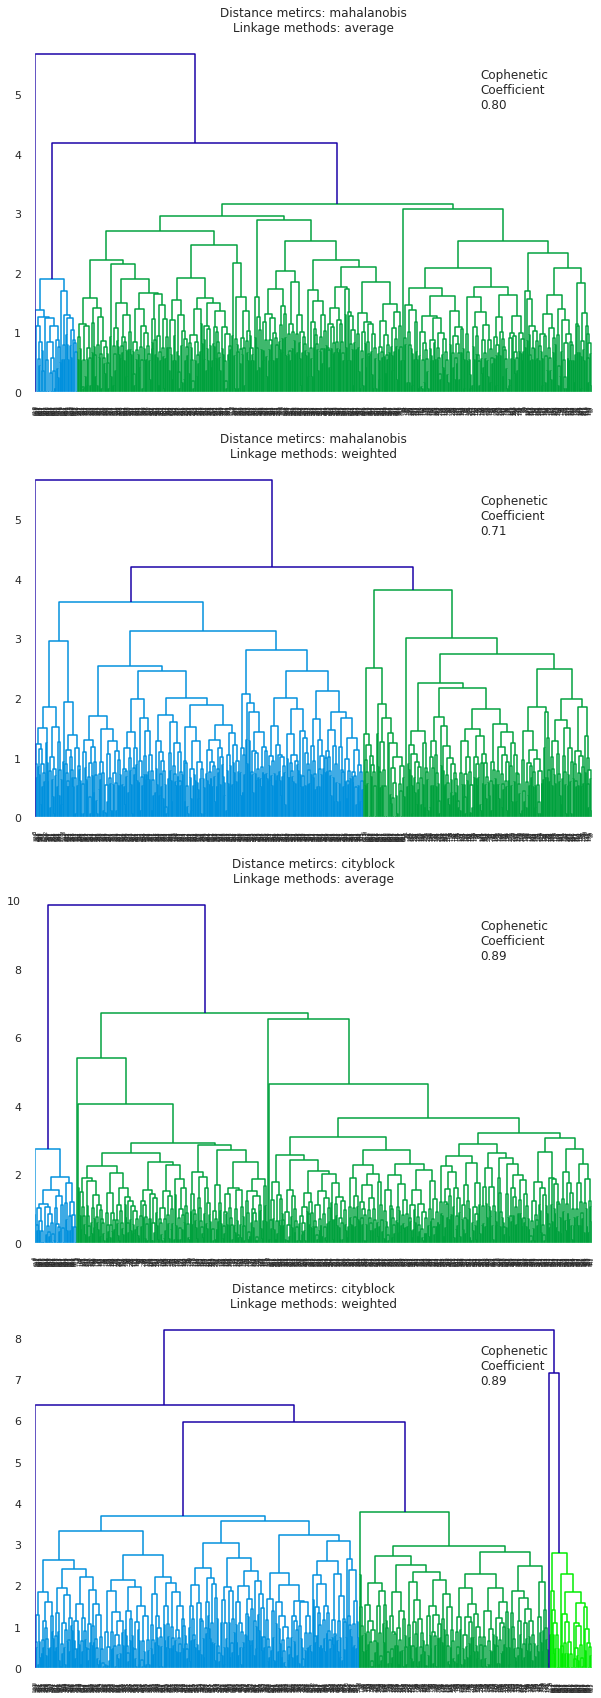

In [68]:
distance_metrics = [ 'mahalanobis','cityblock']
linkage_methods = ['average', 'weighted']
# Create a subplot image
fig, axs = plt.subplots(len(distance_metrics)+len(distance_metrics), 1, figsize=(10, 30))
i=0
for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        dendrogram(Z,  ax=axs[i]);
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))
        coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
        axs[i].annotate(f'Cophenetic\nCoefficient\n{coph_corr:0.2f}', 
                        (0.80, 0.80),
                        xycoords='axes fraction')
        axs[i].set_title('Distance metircs: {}\nLinkage methods: {}'.format(dm,lm))                        
        i +=1

**Observations**

The cophenetic correlation is highest for average linkage methods.
3 appears to be the appropriate number of clusters from the dendrogram for average linkage.

**Build Agglomerative Clustering model**

In [69]:
#Trying with K value as 3
HCmodel = AgglomerativeClustering(n_clusters=3,affinity='euclidean', linkage="average")
HCmodel.fit(subset_scaled_df)
subset_scaled_df['HC_Clusters'] = HCmodel.labels_

In [70]:
cccd['HC_Clusters'] = HCmodel.labels_
cluster_profile = cccd.groupby('HC_Clusters').mean()
cluster_profile['count_in_each_segments'] = cccd.groupby('HC_Clusters')['Avg_Credit_Limit'].count().values


In [71]:
 #lets display cluster profile


cluster_profile.style.highlight_max(color='lightgreen').highlight_min(color='pink')

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_segments,count_in_each_segments
HC_Clusters,,,,,,,
0,25725.589226,4.361953,2.547138,1.935185,3.821549,1.895623,594
1,101448.979592,8.775510,0.591837,8.204082,1.102041,2.000000,49
2,100000.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1


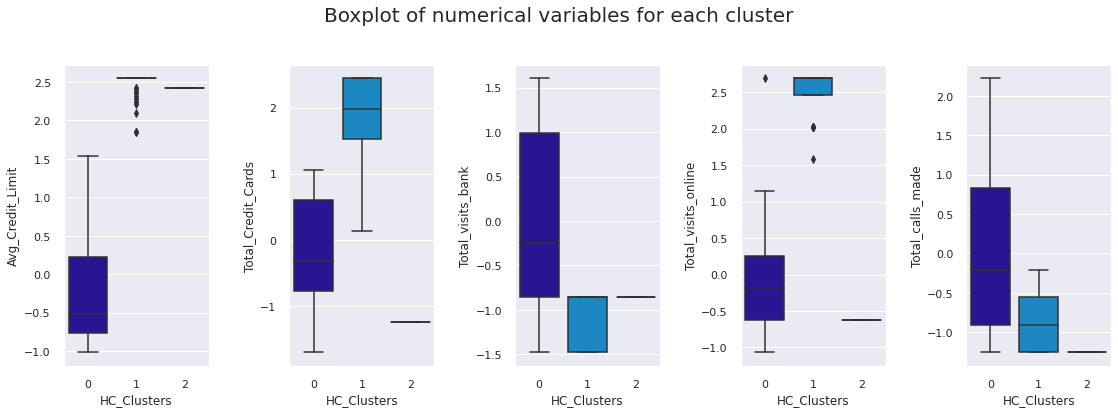

In [72]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=subset_scaled_df[all_col[counter]],x=subset_scaled_df['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

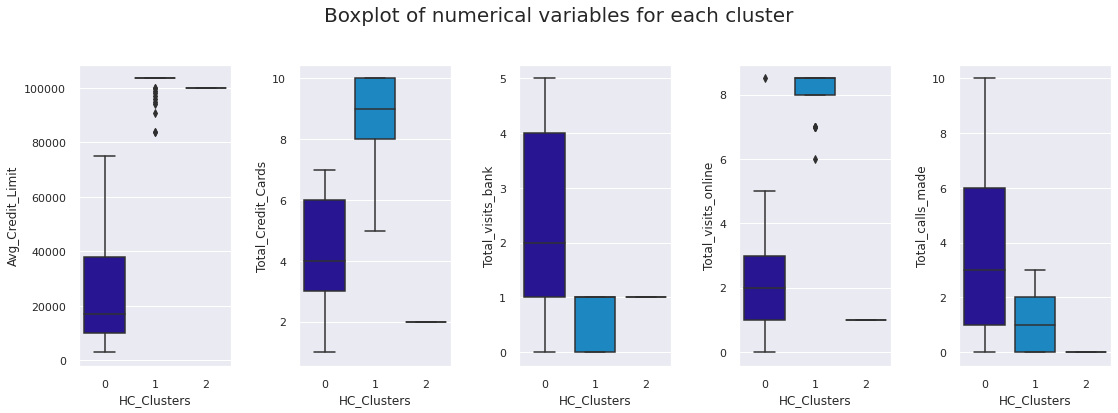

In [73]:
fig, axes = plt.subplots(1, 5,  figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster', fontsize=20)
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii],y=cccd[all_col[counter]],x=cccd['HC_Clusters'])
    counter = counter+1

fig.tight_layout(pad=2.0)

**Insights**

**Cluster 0:**

* This cluster has average credit limit of less than 25,000
* The total number of credit cards is of 1 to 3 in range
* The total visits to the bank is at the most 2 visits we can see in this cluster
* The total visits via online is at the most 4 visits we can see in this cluster.
* The total calls made ranges from 5 at the minimum upto around 9 calls in this cluster.

**Cluster 1:**

* This cluster has average credit limit ranges from 25,000 to above 50,000 but less than 75,000.
* The total number of credit cards range starts at the maxiumum 5 in this cluster.
* The total visits to the bank ranges between 2 to 3 in this cluster.
* The total visits via online is at the most 2 visits we can see in this cluster.
* The total calls made ranges from 1 to 3 calls in this cluster.

**Cluster 2:**

* This cluster has average credit limit ranges higher than 100000 to 175 0000
* The total number of credit cards is of 8 to 10 in range.
* The total visits to the bank is at the most 1 visit only .
* The total visits via online is at the 8 to 13 we can see in this cluster.
* The total calls made ranges from 0 at the minimum upto around 2 calls in this cluster.

**Cluster 3:**

* This cluster has average credit limit of about below 50,000 in this cluster.
* The total number of credit cards is of 4 to 6 in range
* The total visits to the bank is at the maximum 5 visits we can see in this cluster
* The total visits via online is at the most 2 visits we can see in this cluster.
* The total calls made ranges from 1 to 3 calls in this cluster

In [74]:
pd.crosstab(cccd['HC_Clusters'], cccd.Avg_Credit_Limit).style.highlight_max(color = 'lightgreen', axis = 0)

Avg_Credit_Limit,3000.0,5000.0,6000.0,7000.0,8000.0,9000.0,10000.0,11000.0,12000.0,13000.0,14000.0,15000.0,16000.0,17000.0,18000.0,19000.0,20000.0,25000.0,26000.0,27000.0,28000.0,29000.0,30000.0,31000.0,32000.0,33000.0,34000.0,35000.0,36000.0,37000.0,38000.0,39000.0,40000.0,41000.0,42000.0,43000.0,44000.0,45000.0,46000.0,47000.0,48000.0,49000.0,50000.0,51000.0,52000.0,54000.0,55000.0,56000.0,57000.0,58000.0,59000.0,60000.0,61000.0,62000.0,63000.0,64000.0,65000.0,66000.0,67000.0,68000.0,69000.0,70000.0,71000.0,72000.0,73000.0,74000.0,75000.0,84000.0,91000.0,94000.0,95000.0,96000.0,97000.0,98000.0,99000.0,100000.0,103500.0
HC_Clusters,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,20,30,24,32,27,25,24,17,28,23,17,22,22,22,26,20,1,5,2,3,5,6,5,2,4,6,2,11,6,8,7,3,6,2,1,3,3,3,5,6,4,8,4,5,4,1,7,3,3,3,4,3,3,2,4,5,4,2,7,4,10,4,3,4,6,2,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,1,1,1,1,1,2,38
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


**PCA for Dimensionality Reduction**

In [75]:
data_scaled_df_pca = subset_scaled_df
pca = PCA()
pca.fit(data_scaled_df_pca)

PCA()

**Let's check the variance explained by individual components.**

In [76]:
pca.explained_variance_ratio_

array([0.46762202, 0.34957077, 0.06357405, 0.06154909, 0.05479552,
       0.00288855])

Text(0, 0.5, 'Cumulative Explained Variance')

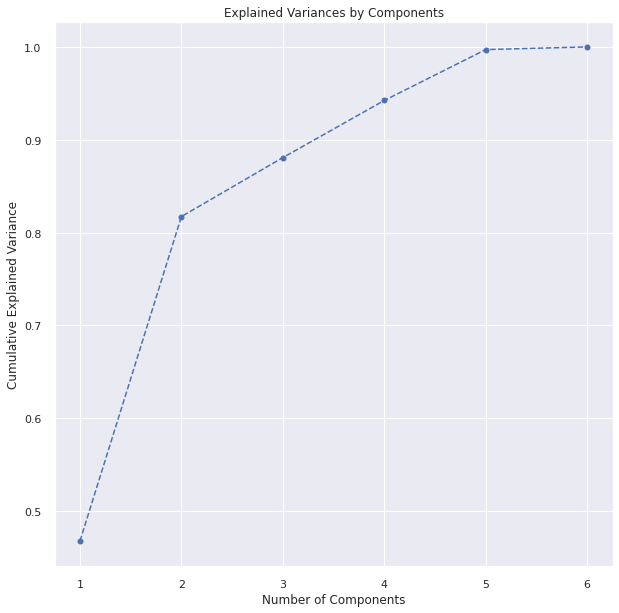

In [77]:
# visualizing the variance explained by individual principal components
sns.set(style='darkgrid')
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 7), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

For 90% variance explained, the number of components looks to be 3.

In [78]:
pca = PCA(
    n_components=3, svd_solver="full"
)  # svd_solver=full helps in faster convergence in case of very large data set
pca.fit(data_scaled_df_pca)

PCA(n_components=3, svd_solver='full')

In [79]:
# checking the variance explained by individual components.
print('Explained variance = {var} %'.format(var=round(pca.explained_variance_ratio_.sum(),2)*100))

Explained variance = 88.0 %


Text(0, 0.5, 'Cumulative Explained Variance')

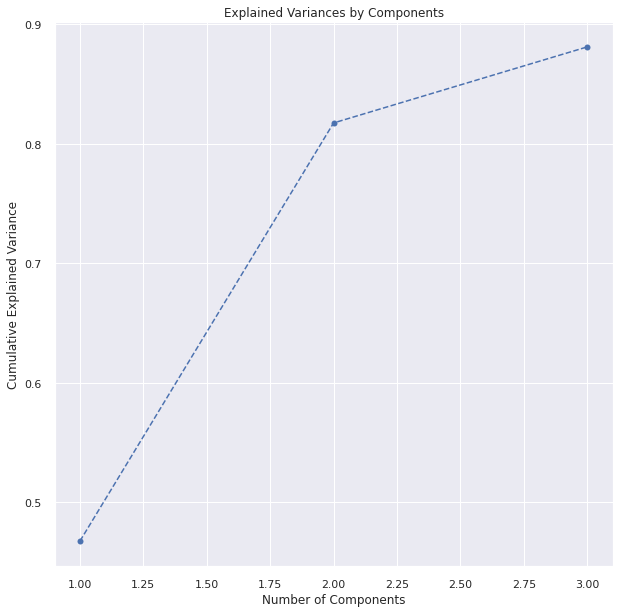

In [80]:
plt.figure(figsize=(10, 10))
plt.plot(
    range(1, 4), pca.explained_variance_ratio_.cumsum(), marker="o", linestyle="--"
)
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")

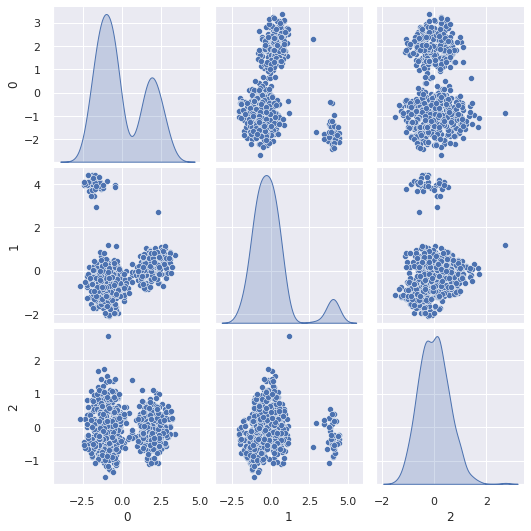

In [81]:
subset_pca = pca.transform(data_scaled_df_pca)
subset_pca_df = pd.DataFrame(subset_pca)
sns.pairplot(subset_pca_df, diag_kind='kde');

**Hierarchical Clustering on lower-dimensional data**

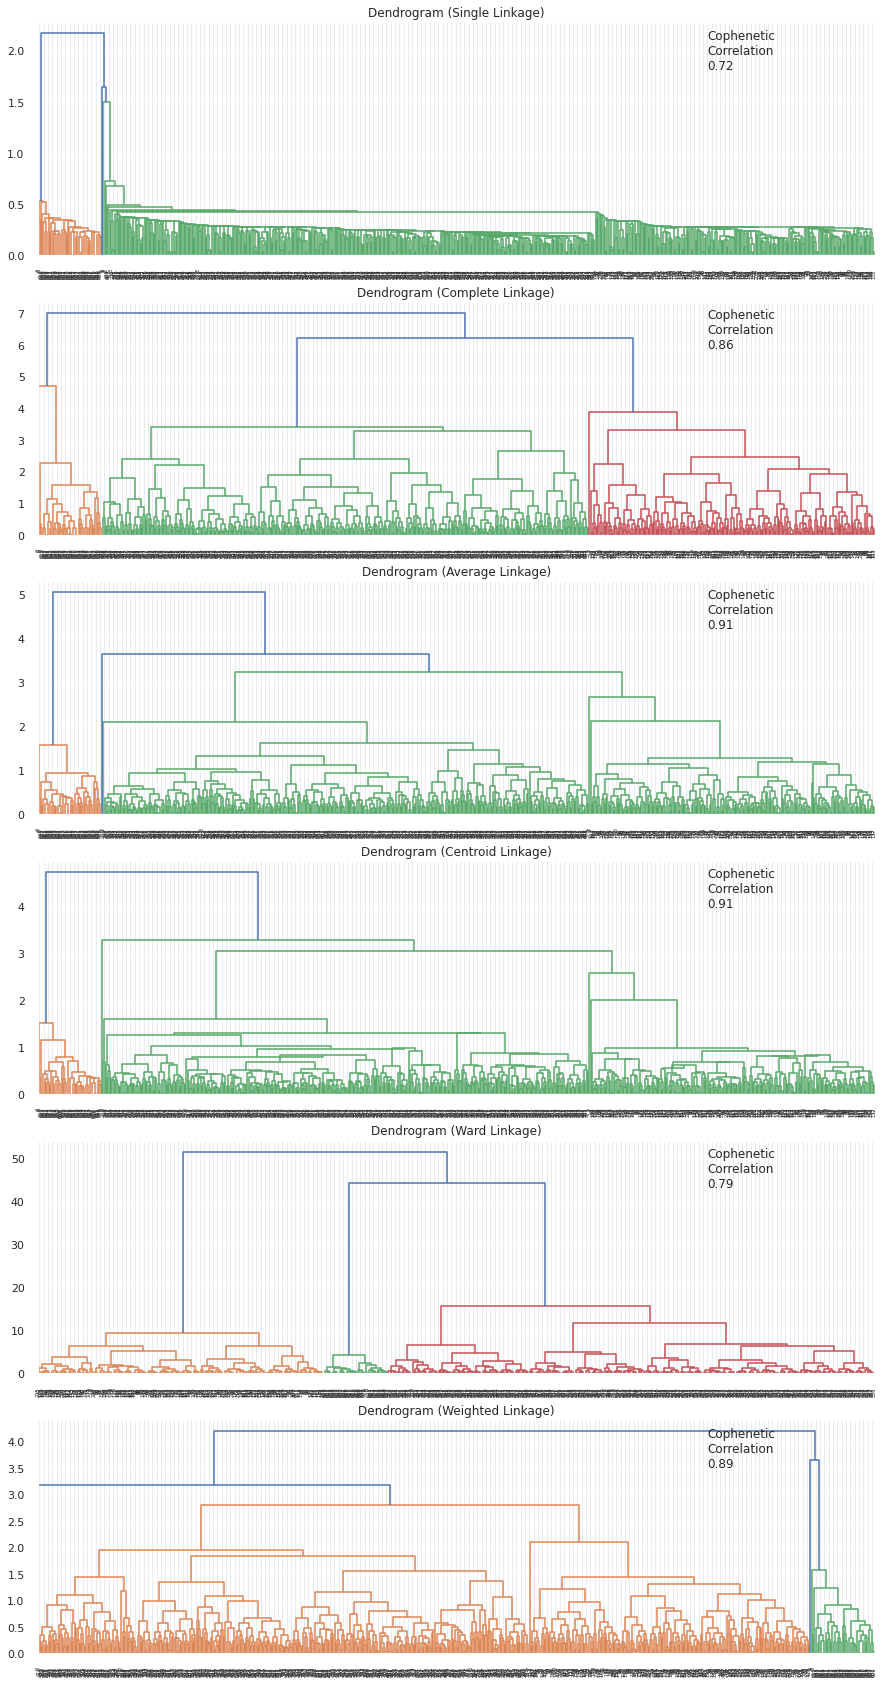

In [82]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_pca_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_pca_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )

**Observations**

The cophenetic correlation is highest for average and centroid linkage method, but I will check with complete linkage as it has more distinct and separated clusters, and a cophenetic correlation of 0.89 (highest being 0.9).
3 appears to be the appropriate number of clusters from the dendrogram for complete linkage as well.

In [83]:
hc = AgglomerativeClustering(n_clusters=3, affinity="euclidean", linkage="complete")
hc_labels = hc.fit_predict(subset_pca)
# adding hierarchical cluster labels to the original dataframe
#data_pca = data.drop(['cluster', 'hc_cluster'], axis=1)
subset_pca_df['pca_hc_cluster'] = hc_labels
subset_pca_df['customer_key'] = data['Customer Key']


**Cluster Profiling**

In [84]:
cluster_profile2 = subset_pca_df.groupby('pca_hc_cluster').mean()
cluster_profile2['customer_count'] = (
    subset_pca_df.groupby('pca_hc_cluster')['customer_key'].count().values
)
# let's display cluster profile
cluster_profile2.style.highlight_max(color="lightgreen", axis=0)

,0,1,2,customer_key,customer_count
pca_hc_cluster,,,,,
0,-1.718741,3.931602,-0.186537,57189.340000,50
1,1.973463,0.242815,-0.011775,55128.759091,220
2,-0.931082,-0.668448,0.031864,54882.534759,374


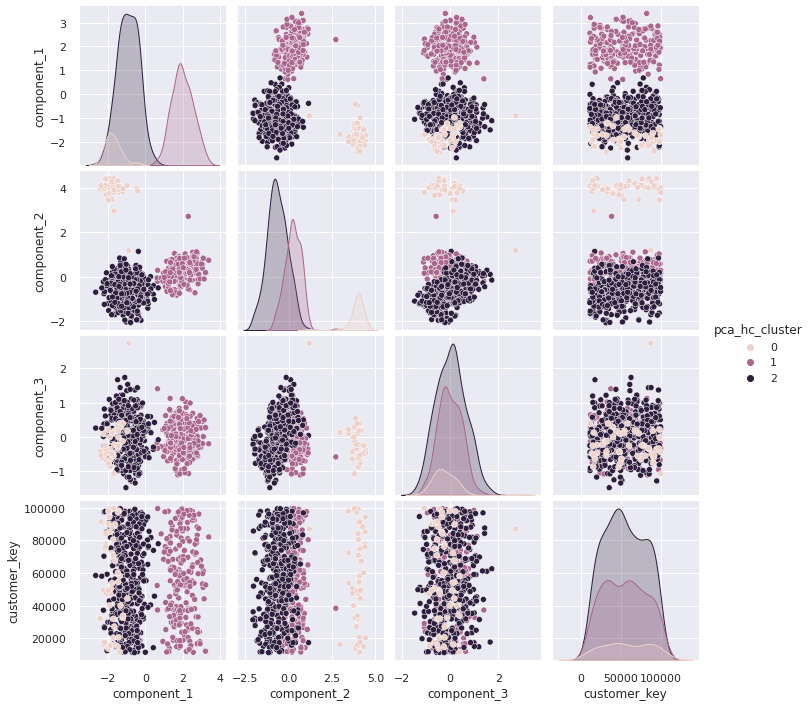

In [85]:
pca_df = subset_pca_df.copy()
pca_df['pca_hc_cluster'] = hc_labels

pca_df = pca_df.rename(columns={0:'component_1', 1:'component_2', 2:'component_3'})
sns.pairplot(pca_df, diag_kind='kde', hue='pca_hc_cluster');

**Comparing Hierarchical Methods**

**Comparing K-Means and Hierarchical**

In [86]:
# Loading saved silhouette scores, only selecting the highest
sil_com = [sil_score[1], avg_sil_score[1]]


# Making labels for each method
types = ["K-means", "Average Hierarchical"]

# Creating a dataframe for comparisons
cross_compare = pd.DataFrame(
    {"Silhouette Score": sil_com}, index=types,
)
# Displaying comparison
cross_compare

,Silhouette Score
K-means,0.517171
Average Hierarchical,0.346844


**The average linkage method for hierarchical clustering beat out k-means both times just barely.**

**Comparison Conclusion**

Overall I think the K-means clustering method performed better subjectively. While the second difference was quite uncertain, the first difference was very clear. Thus, while they performed similarly, I prefer K-means on this measure.

The hierarchical method did better slightly quantitatively, with superior a superior silhouette score . However, this advantage was very small.

The current database is extremely small. As it increases in size, the agglomerative clustering method becomes more and more computationally intense. Meanwhile, k-means is appropriate to use even on large amounts of data.

It is thus my opinion that the ever-so-slighty better performance of the agglomerative clustering method does not justify being brought into production for classifying future customers. Its performance is too close to k-means to warrant the extra computing power.

I recommend continuing with the k-means model

**Actionable insights and Recommendations**

*There appears to be three distinct categories of customers:*

**In-person users:** prefer to handle bank transactions in person. They have the medium number of credit cards and the medium available credit. They are also the most active users.

**Phone users:** prefer verbally handling transactions. They have fewest credit cards and lowest credit card limit.

**Online users:** prefer digital transactions. They also have the most credit cards and the highest available credit. Least number of customers have this type of behaviour.

The customer preferences should be used to contact the customers. Online/phone users will probably prefer email/text notifications, while in-person users prefer mail notifications and upselling (when at the bank location).

Also, the phone and in-person customers should be reached out to promote online banking. 